In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
import pandas as pd
import time
from datetime import timedelta
import math
import dataset
import random
import os
import cache

In [2]:
import vgg16
from vgg16 import transfer_values_cache
from vgg16 import transfer_values_calc

In [3]:
vgg16.maybe_download()
model=vgg16.VGG16()

Data has apparently already been downloaded and unpacked.


In [55]:
classes=['0','1','2','3','4','5','6','7','8','9','A','A_LOW','B','B_LOW','C','C_LOW','D','D_LOW','E','E_LOW','F','F_LOW','G',
         'G_LOW','H','H_LOW','I','I_LOW','J','J_LOW','K','K_LOW','L','L_LOW','M','M_LOW','N','N_LOW','O','O_LOW','P','P_LOW','Q',
         'Q_LOW','R','R_LOW','S','S_LOW','T','T_LOW','U','U_LOW','V','V_LOW','W','W_LOW','X','X_LOW','Y','Y_LOW','Z','Z_LOW']
class_numbers=list(range(62))
num_classes=len(classes)
num_channels=3
validation_size = .2
img_size = 128
img_size_flat=img_size*img_size*num_channels
#custom paths
train_path = 'C:/Users/Konstantin/Machine Learning/NIST Handwritten project/NIST/train'
test_path = 'C:/Users/Konstantin/Machine Learning/NIST Handwritten project/NIST/test'
cache_path= 'C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST'

In [5]:
#first time loading
train_data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_data = dataset.read_test_set(test_path, img_size,classes)

Reading training images
Loading 0 files (Index: 0)
Loading 1 files (Index: 1)
Loading 2 files (Index: 2)
Loading 3 files (Index: 3)
Loading 4 files (Index: 4)
Loading 5 files (Index: 5)
Loading 6 files (Index: 6)
Loading 7 files (Index: 7)
Loading 8 files (Index: 8)
Loading 9 files (Index: 9)
Loading A files (Index: 10)
Loading A_LOW files (Index: 11)
Loading B files (Index: 12)
Loading B_LOW files (Index: 13)
Loading C files (Index: 14)
Loading C_LOW files (Index: 15)
Loading D files (Index: 16)
Loading D_LOW files (Index: 17)
Loading E files (Index: 18)
Loading E_LOW files (Index: 19)
Loading F files (Index: 20)
Loading F_LOW files (Index: 21)
Loading G files (Index: 22)
Loading G_LOW files (Index: 23)
Loading H files (Index: 24)
Loading H_LOW files (Index: 25)
Loading I files (Index: 26)
Loading I_LOW files (Index: 27)
Loading J files (Index: 28)
Loading J_LOW files (Index: 29)
Loading K files (Index: 30)
Loading K_LOW files (Index: 31)
Loading L files (Index: 32)
Loading L_LOW file

In [6]:
from cache import cache_nof
#custom cache paths
images_train_data_path = os.path.join(cache_path, 'images_train.pkl')
cls_train_data_path=os.path.join(cache_path, 'cls_train.pkl')
labels_train_data_path=os.path.join(cache_path, 'labels_train.pkl')
ids_train_data_path=os.path.join(cache_path, 'ids_train.pkl')
images_valid_data_path=os.path.join(cache_path, 'images_valid.pkl')
cls_valid_data_path=os.path.join(cache_path, 'cls_valid.pkl')
labels_valid_data_path=os.path.join(cache_path, 'labels_valid.pkl')
ids_valid_data_path=os.path.join(cache_path, 'ids_valid.pkl')
images_test_data_path=os.path.join(cache_path, 'images_test.pkl')
cls_test_data_path=os.path.join(cache_path, 'cls_test.pkl')
ids_test_data_path=os.path.join(cache_path, 'ids_test.pkl')
labels_test_data_path=os.path.join(cache_path, 'labels_test.pkl')

images_train=cache_nof(images_train_data_path,train_data.train.images)
cls_train=cache_nof(cls_train_data_path,train_data.train.cls)
labels_train=cache_nof(labels_train_data_path,train_data.train.labels)
ids_train=cache_nof(ids_train_data_path,train_data.train.ids)
images_valid=cache_nof(images_valid_data_path,train_data.valid.images)
cls_valid=cache_nof(cls_valid_data_path,train_data.valid.cls)
labels_valid=cache_nof(labels_valid_data_path,train_data.valid.labels)
ids_valid=cache_nof(ids_valid_data_path,train_data.valid.ids)
images_test=cache_nof(images_test_data_path,test_data.test.images)
cls_test=cache_nof(cls_test_data_path,test_data.test.cls)
labels_test=cache_nof(labels_test_data_path,test_data.test.labels)
ids_test=cache_nof(ids_test_data_path,test_data.test.ids)

- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\images_train.pkl
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\cls_train.pkl
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\labels_train.pkl
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\ids_train.pkl
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\images_valid.pkl
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\cls_valid.pkl
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\labels_valid.pkl
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\ids_valid.pkl
- Data loaded from cache-file: C:/Users/Kons

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(train_data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_data.test.labels)))
print("- Validation-set:\t{}".format(len(train_data.valid.labels)))
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        ax.imshow(images[i].reshape(img_size, img_size, num_channels))


        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

Size of:
- Training-set:		80000
- Test-set:		31000
- Validation-set:	20000


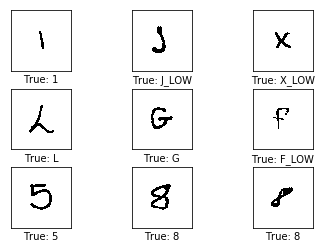

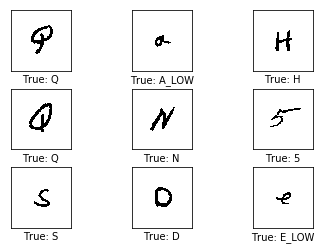

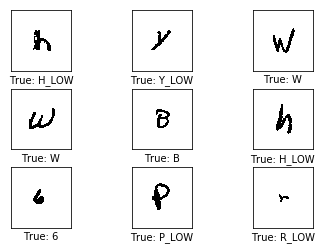

In [8]:

plot_images(images=images_train, cls_true=cls_train)
plot_images(images=images_valid, cls_true=cls_valid)
plot_images(images=images_test, cls_true=cls_test)

In [9]:
file_path_cache_train = os.path.join(cache_path, 'vgg16_train_full_pool5.pkl')
file_path_cache_test = os.path.join(cache_path, 'vgg16_test_full_pool5.pkl')
file_path_cache_valid = os.path.join(cache_path, 'vgg16_valid_full_pool5.pkl')

In [10]:
print("Processing VGG 16 transfer-values for training-images ...")

transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_train,
                                              model=model)

Processing VGG 16 transfer-values for training-images ...
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\vgg16_train_full_pool5.pkl


In [11]:
print("Processing VGG 16 transfer-values for test-images ...")

transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_test,
                                             model=model)

Processing VGG 16 transfer-values for test-images ...
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\vgg16_test_full_pool5.pkl


In [12]:
print("Processing VGG 16 transfer-values for validation-images ...")

transfer_values_valid = transfer_values_cache(cache_path=file_path_cache_valid,
                                             images=images_valid,
                                             model=model)

Processing VGG 16 transfer-values for validation-images ...
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\vgg16_valid_full_pool5.pkl


In [13]:
transfer_values_train_r=transfer_values_train.reshape(len(train_data.train.labels),8192)
transfer_values_test_r=transfer_values_test.reshape(len(test_data.test.labels),8192)
transfer_values_valid_r=transfer_values_valid.reshape(len(train_data.valid.labels),8192)

In [14]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using VGG16 model:")
    
    img = transfer_values_test_r[i]
    img = img.reshape((64,128))

    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


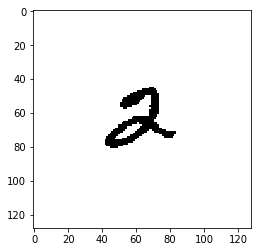

Transfer-values for the image using VGG16 model:


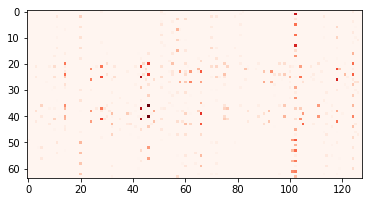

In [15]:
plot_transfer_values(i=1000)

Input image:


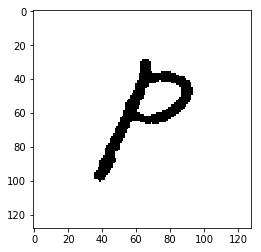

Transfer-values for the image using VGG16 model:


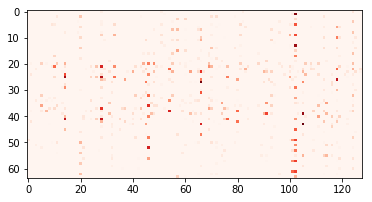

In [16]:
plot_transfer_values(i=20253)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transfer_values = transfer_values_train_r[0:6000]
cls = cls_train[0:6000]

In [18]:
transfer_values.shape

(6000, 8192)

In [19]:
transfer_values_reduced = pca.fit_transform(transfer_values)

In [20]:
transfer_values_reduced.shape

(6000, 2)

In [21]:
def plot_scatter(values, cls):
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1, num_classes))

    colors = cmap[cls]

    x = values[:, 0]
    y = values[:, 1]

    plt.scatter(x, y, color=colors)
    plt.show()

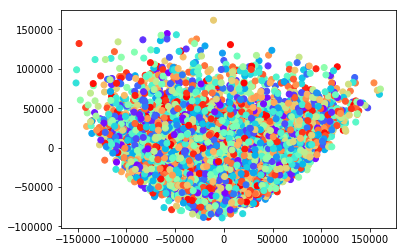

In [22]:
plot_scatter(transfer_values_reduced, class_numbers)

In [14]:
transfer_len=8192
labels_test[0:5,:]


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
      

In [125]:
cls_test = np.array([label.argmax() for label in labels_test])
cls_valid = np.array([label.argmax() for label in labels_valid])

In [133]:
x = tf.placeholder(tf.float32, [None, transfer_len],name='x')
y_true = tf.placeholder(tf.float32, [None, num_classes],name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)
weights = tf.Variable(tf.zeros([transfer_len, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [134]:
optimizer = tf.train.AdagradOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [135]:
session = tf.Session()
saver = tf.train.Saver()
session.run(tf.global_variables_initializer())
batch_size = 4000
def random_batch():
    num_images = len(transfer_values_train_r)

    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    x_batch = transfer_values_train_r[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch
def random_batch_valid():
    num_images = len(transfer_values_valid_r)

    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    x_batch = transfer_values_valid_r[idx]
    y_batch = labels_valid[idx]

    return x_batch, y_batch
def optimize(num_iterations):
    saver = tf.train.Saver()
    start_time = time.time()
    for i in range(num_iterations):
        x_batch, y_true_batch=random_batch()
        x_batch_val, y_true_batch_val=random_batch_valid()
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        feed_dict_valid = {x: x_batch_val,
                           y_true: y_true_batch_val}
        session.run(optimizer, feed_dict=feed_dict_train)
        #session.run(optimizer, feed_dict=feed_dict_valid)
        # Print status every 100 iterations.
        if i % 100 == 0:
                    
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
            print_accuracy_test()
            
    save_path=saver.save(session, 'C:/Users/Konstantin/Machine Learning/NIST Handwritten project/NIST_classifier/model_save/my_model',
              global_step=num_iterations) 
    print("Model saved in file: %s" % save_path)
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
  


In [136]:
feed_dict_test = {x: transfer_values_test_r,
                  y_true: labels_test}
feed_dict_train = {x: transfer_values_train_r,
                  y_true: labels_train}
feed_dict_valid = {x: transfer_values_valid_r,
                  y_true: labels_valid}

In [137]:
def print_accuracy_test():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))
def print_accuracy_valid():
    acc_valid=session.run(accuracy, feed_dict=feed_dict_valid)
    print("Accuracy on validation-set: {0:.1%}".format(acc_valid))

In [138]:
def plot_example_errors():

    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## No optimization

Accuracy on test-set: 1.6%


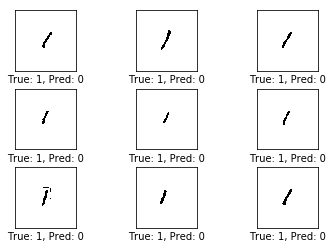

In [139]:
print_accuracy_test()
plot_example_errors()

## 1 iteration opt

Optimization Iteration:      1, Training Accuracy:  20.0%
Accuracy on validation-set: 17.6%
Accuracy on test-set: 12.2%
Model saved in file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/NIST_classifier/model_save/my_model-1
Time usage: 0:00:07
Accuracy on test-set: 12.2%


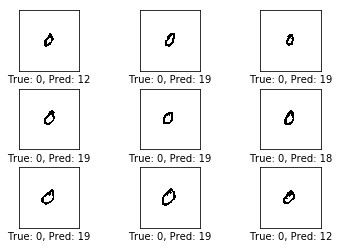

In [140]:

optimize(num_iterations=1)
print_accuracy_test()
plot_example_errors()

## 1000 iteration opt

Optimization Iteration:      1, Training Accuracy:  19.7%
Accuracy on validation-set: 18.3%
Accuracy on test-set: 19.7%
Optimization Iteration:    101, Training Accuracy:  81.0%
Accuracy on validation-set: 74.7%
Accuracy on test-set: 77.2%
Optimization Iteration:    201, Training Accuracy:  87.6%
Accuracy on validation-set: 79.0%
Accuracy on test-set: 83.9%
Optimization Iteration:    301, Training Accuracy:  88.5%
Accuracy on validation-set: 79.0%
Accuracy on test-set: 85.4%
Optimization Iteration:    401, Training Accuracy:  88.9%
Accuracy on validation-set: 78.8%
Accuracy on test-set: 85.9%
Optimization Iteration:    501, Training Accuracy:  92.2%
Accuracy on validation-set: 80.2%
Accuracy on test-set: 88.4%
Optimization Iteration:    601, Training Accuracy:  92.8%
Accuracy on validation-set: 81.0%
Accuracy on test-set: 89.8%
Optimization Iteration:    701, Training Accuracy:  93.4%
Accuracy on validation-set: 80.4%
Accuracy on test-set: 89.6%
Optimization Iteration:    801, Training

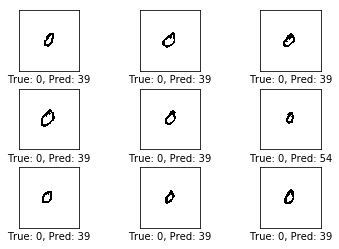

In [141]:
optimize(num_iterations=1000)
print_accuracy_test()
plot_example_errors()

Optimization Iteration:      1, Training Accuracy:  96.0%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 92.1%
Optimization Iteration:    101, Training Accuracy:  96.2%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 92.4%
Optimization Iteration:    201, Training Accuracy:  95.8%
Accuracy on validation-set: 80.9%
Accuracy on test-set: 91.8%
Optimization Iteration:    301, Training Accuracy:  96.5%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 92.5%
Optimization Iteration:    401, Training Accuracy:  95.7%
Accuracy on validation-set: 80.9%
Accuracy on test-set: 92.0%
Optimization Iteration:    501, Training Accuracy:  96.7%
Accuracy on validation-set: 81.2%
Accuracy on test-set: 92.8%
Optimization Iteration:    601, Training Accuracy:  95.6%
Accuracy on validation-set: 81.0%
Accuracy on test-set: 92.2%
Optimization Iteration:    701, Training Accuracy:  97.4%
Accuracy on validation-set: 80.9%
Accuracy on test-set: 93.1%
Optimization Iteration:    801, Training

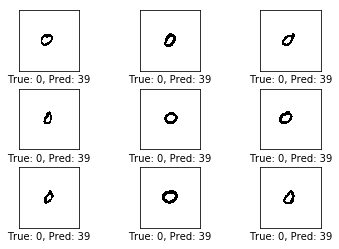

In [142]:
optimize(num_iterations=1000)
print_accuracy_test()
plot_example_errors()

Optimization Iteration:      1, Training Accuracy:  97.3%
Accuracy on validation-set: 81.1%
Accuracy on test-set: 93.4%
Optimization Iteration:    101, Training Accuracy:  95.8%
Accuracy on validation-set: 80.6%
Accuracy on test-set: 92.4%
Optimization Iteration:    201, Training Accuracy:  98.3%
Accuracy on validation-set: 81.2%
Accuracy on test-set: 94.3%
Optimization Iteration:    301, Training Accuracy:  97.7%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 94.2%
Optimization Iteration:    401, Training Accuracy:  97.8%
Accuracy on validation-set: 80.8%
Accuracy on test-set: 93.7%
Optimization Iteration:    501, Training Accuracy:  97.2%
Accuracy on validation-set: 80.9%
Accuracy on test-set: 93.4%
Optimization Iteration:    601, Training Accuracy:  98.8%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 94.8%
Optimization Iteration:    701, Training Accuracy:  98.8%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 94.6%
Optimization Iteration:    801, Training

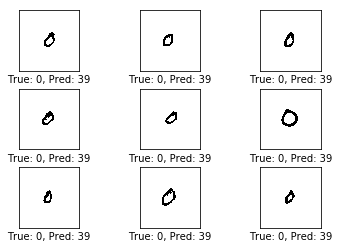

In [143]:
optimize(num_iterations=1000)
print_accuracy_test()
plot_example_errors()

Optimization Iteration:      1, Training Accuracy:  98.6%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 94.7%
Optimization Iteration:    101, Training Accuracy:  98.6%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 94.7%
Optimization Iteration:    201, Training Accuracy:  98.7%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.0%
Optimization Iteration:    301, Training Accuracy:  98.6%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 94.5%
Optimization Iteration:    401, Training Accuracy:  99.1%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.1%
Optimization Iteration:    501, Training Accuracy:  99.0%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.2%
Optimization Iteration:    601, Training Accuracy:  98.8%
Accuracy on validation-set: 81.2%
Accuracy on test-set: 94.6%
Optimization Iteration:    701, Training Accuracy:  98.6%
Accuracy on validation-set: 81.1%
Accuracy on test-set: 94.4%
Optimization Iteration:    801, Training

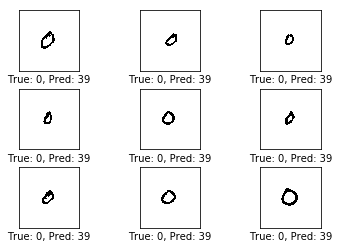

In [144]:
optimize(num_iterations=5000)
print_accuracy_test()
plot_example_errors()

Optimization Iteration:      1, Training Accuracy:  99.2%
Accuracy on validation-set: 81.2%
Accuracy on test-set: 95.2%
Optimization Iteration:    101, Training Accuracy:  99.6%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.6%
Optimization Iteration:    201, Training Accuracy:  99.6%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 95.5%
Optimization Iteration:    301, Training Accuracy:  99.3%
Accuracy on validation-set: 81.2%
Accuracy on test-set: 95.3%
Optimization Iteration:    401, Training Accuracy:  99.5%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 95.4%
Optimization Iteration:    501, Training Accuracy:  99.8%
Accuracy on validation-set: 81.5%
Accuracy on test-set: 95.6%
Optimization Iteration:    601, Training Accuracy:  99.7%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.6%
Optimization Iteration:    701, Training Accuracy:  99.6%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 95.5%
Optimization Iteration:    801, Training

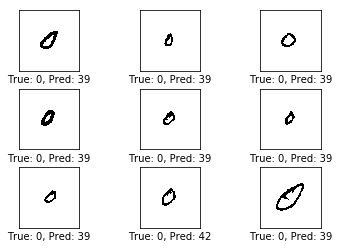

In [145]:
optimize(num_iterations=3000)
print_accuracy_test()
plot_example_errors()

Optimization Iteration:      1, Training Accuracy:  99.4%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 95.5%
Optimization Iteration:    101, Training Accuracy:  99.8%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.7%
Optimization Iteration:    201, Training Accuracy:  99.7%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.7%
Optimization Iteration:    301, Training Accuracy:  99.7%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.5%
Optimization Iteration:    401, Training Accuracy:  99.7%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.7%
Optimization Iteration:    501, Training Accuracy:  99.6%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 95.5%
Optimization Iteration:    601, Training Accuracy:  99.6%
Accuracy on validation-set: 81.3%
Accuracy on test-set: 95.5%
Optimization Iteration:    701, Training Accuracy:  99.7%
Accuracy on validation-set: 81.4%
Accuracy on test-set: 95.7%
Optimization Iteration:    801, Training

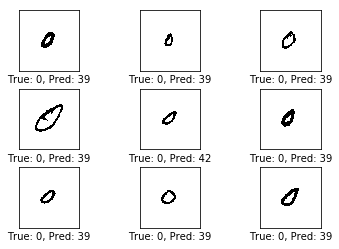

In [146]:
optimize(num_iterations=10000)
print_accuracy_test()
plot_example_errors()

In [156]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = test_data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [157]:
cls_pred = session.run([y_pred_cls],feed_dict=feed_dict_test)

In [158]:
plot_confusion_matrix(cls_pred=cls_pred)

ValueError: Found input variables with inconsistent numbers of samples: [31000, 1]

# Save and reload

## 10000 iteration opt

In [ ]:
optimize(num_iterations=10000)
print_accuracy_test()
plot_example_errors()

In [ ]:
optimize(num_iterations=1000)
print_accuracy_test()
plot_example_errors()

In [ ]:

def plot_examples_test():

    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[197:],
                cls_true=cls_true[197:],
                cls_pred=cls_pred[197:])

In [ ]:
plot_examples_test()

In [ ]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(2, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        ax.imshow(images[i].reshape(img_size, img_size, num_channels))


        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
def plot_examples_valid():

    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_valid)

    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:],
                cls_true=cls_true[0:],
                cls_pred=cls_pred[0:])

In [ ]:
plot_examples_valid()

## Load a new image for testing

In [ ]:
custom_path='C:/Users/Konstantin/Machine Learning/NIST Handwritten project/NIST_classifier/custom'
custom_test_data=dataset.read_custom_image(custom_path, img_size,classes)
custom_image_test=custom_test_data.test.images
custom_cls_test=custom_test_data.test.cls
custom_label_test=custom_test_data.test.labels
custom_id_test=custom_test_data.test.ids

In [ ]:
def plot_custom_image(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(1, 1)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    axes.imshow(images[0].reshape(img_size,img_size,num_channels))


    if cls_pred is None:
        xlabel = "True: {0}".format(cls_true[0])
    else:
        xlabel = "True: {0}, Pred: {1}".format(cls_true[0], cls_pred[0])

    axes.set_xlabel(xlabel)
    axes.set_xticks([])
    axes.set_yticks([])
    
    plt.show()

plot_custom_image(images=custom_image_test, cls_true=custom_cls_test)

In [ ]:
print("Processing VGG 16 transfer-value for custom image ...")
custom_file_path_cache_test = os.path.join(cache_path, 'vgg16_custom.pkl')
custom_transfer_value_test = transfer_values_calc(images=custom_image_test,
                                             model=model)

In [ ]:
custom_transfer_value_test_r=custom_transfer_value_test.reshape(len(custom_test_data.test.labels),8192)

In [ ]:
custom_cls_test = np.array([label.argmax() for label in custom_label_test])

In [ ]:

feed_dict_test = {x: custom_transfer_value_test_r,
                  y_true: custom_label_test,
                  y_true_cls: custom_cls_test}

In [ ]:
def plot_custom_image(images, cls_true, cls_pred):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(1, 1)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    axes.imshow(images[0].reshape(img_size, img_size, num_channels))


    if cls_pred is None:
        xlabel = "True: {0}".format(cls_true[0])
    else:
        xlabel = "True: {0}, Pred: {1}".format(cls_true[0], cls_pred[0])

    axes.set_xlabel(xlabel)
    axes.set_xticks([])
    axes.set_yticks([])
    
    plt.show()
    
plot_custom_image(images=custom_image_test, cls_true=custom_cls_test,cls_pred = session.run([y_pred_cls],
                                    feed_dict=feed_dict_test))

In [ ]:
optimize(num_iterations=100)

In [ ]:
plot_custom_image(images=custom_image_test, cls_true=custom_cls_test,cls_pred = session.run([y_pred_cls],
                                    feed_dict=feed_dict_test))

In [ ]:
optimize(num_iterations=1000)

In [ ]:
plot_custom_image(images=custom_image_test, cls_true=custom_cls_test,cls_pred = session.run([y_pred_cls],
                                    feed_dict=feed_dict_test))